In [1]:
import pyslammer as slam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib widget


In [2]:
# Load the northridge ground motion
histories = slam.sample_ground_motions()
motion = histories["Northridge_PAC-175"]
scaled_pga = 0.4
Tm = 0.47  # seconds (period of the ground motion)
output = {}

# Set range of ky values
k_max_set = np.asarray([0.41, 0.55, 0.19, 0.08])
kykmaxs = np.linspace(0.1, 0.9, 9)

# Set range of Ts/Tm values
TsTms = np.asarray([0.2, 1.0, 2.0, 8.0])

# Version 1 (constant slope height)
version_1 = False
default_height = 30  # meters
default_vs = 600  # meters per second
# H = 30 # meters
# Vs = 4*H/(TsTms*Tm) # meters per second

# Version 2 (constant shear wave velocity)
# Vs = 600 # meters per second
# H = Vs * TsTms * Tm / 4 # meters

rigid_inputs = {"a_in": motion.accel, "dt": motion.dt, "target_pga": scaled_pga}
flexible_inputs = {
    "damp_ratio": -0.05,
    "ref_strain": 0.0005,
    "soil_model": "linear_elastic",
}
run = 0
for kykmax in kykmaxs:
    # rigid_inputs["ky"] = float(ky)
    for i, TsTm in enumerate(TsTms):
        ky = k_max_set[i] * kykmax
        rigid_inputs["ky"] = ky
        if version_1:
            flexible_inputs["height"] = default_height
            Vs = 4 * default_height / (TsTm * Tm)
            flexible_inputs["vs_slope"] = Vs
            flexible_inputs["vs_base"] = Vs
        else:
            flexible_inputs["height"] = TsTm * Tm * default_vs / 4
            flexible_inputs["vs_slope"] = default_vs
            flexible_inputs["vs_base"] = default_vs

        rigid_result = slam.RigidAnalysis(**rigid_inputs)
        decoupled_result = slam.Decoupled(**rigid_inputs, **flexible_inputs)
        coupled_result = slam.Coupled(**rigid_inputs, **flexible_inputs)
        output[run] = {
            "ky": round(ky, 3),
            "Ts/Tm": round(TsTm, 2),
            "H": round(flexible_inputs["height"], 2),
            "Vs": round(flexible_inputs["vs_slope"], 2),
            "rigid_disp": rigid_result.max_sliding_disp*100,
            "decoupled_disp": decoupled_result.max_sliding_disp*100,
            "coupled_disp": coupled_result.max_sliding_disp*100,
            "k_max (decoupled)": np.max(decoupled_result.HEA)/9.81,
        }
        run += 1


In [3]:
histories

{'Morgan_Hill_1984_CYC-285': <pyslammer.record.GroundMotion at 0x12d747cb0>,
 'Nisqually_2001_UNR-058': <pyslammer.record.GroundMotion at 0x12c4021b0>,
 'Imperial_Valley_1979_BCR-230': <pyslammer.record.GroundMotion at 0x12e00f560>,
 'Chi-Chi_1999_TCU068-090': <pyslammer.record.GroundMotion at 0x12c402180>,
 'Cape_Mendocino_1992_PET-090': <pyslammer.record.GroundMotion at 0x12e3fcec0>,
 'Coalinga_1983_PVB-045': <pyslammer.record.GroundMotion at 0x12e3fcd70>,
 'Mammoth_Lakes-2_1980_CVK-090': <pyslammer.record.GroundMotion at 0x12e3fc200>,
 'Northridge_VSP-360': <pyslammer.record.GroundMotion at 0x12e4b78f0>,
 'Kocaeli_1999_ATS-090': <pyslammer.record.GroundMotion at 0x12e4b79b0>,
 'Nahanni_1985_NS1-280': <pyslammer.record.GroundMotion at 0x12e4b7980>,
 'Mammoth_Lakes-1_1980_CVK-090': <pyslammer.record.GroundMotion at 0x12e4b79e0>,
 'Northridge_PAC-175': <pyslammer.record.GroundMotion at 0x12e4b7a10>,
 'Duzce_1999_375-090': <pyslammer.record.GroundMotion at 0x12e4b7a40>,
 'Loma_Prieta_19

In [3]:
# convert the output to a pandas dataframe
df = pd.DataFrame.from_dict(output, orient="index")
df


,ky,Ts/Tm,H,Vs,rigid_disp,decoupled_disp,coupled_disp,k_max (decoupled)
0,0.041,0.2,14.1,600,1.485338e+01,14.648809,21.255319,0.416887
1,0.055,1.0,70.5,600,1.211373e+01,40.159310,13.243343,0.551968
2,0.019,2.0,141.0,600,2.460523e+01,32.468718,13.919614,0.194279
3,0.008,8.0,564.0,600,4.444053e+01,26.174393,21.530409,0.081419
4,0.082,0.2,14.1,600,8.601780e+00,8.846988,8.879025,0.416887
5,0.110,1.0,70.5,600,5.884447e+00,25.783776,8.338071,0.551968
6,0.038,2.0,141.0,600,1.556241e+01,14.382819,7.262949,0.194279
7,0.016,8.0,564.0,600,2.829736e+01,5.595389,9.149602,0.081419
8,0.123,0.2,14.1,600,4.885718e+00,5.234873,7.210171,0.416887
9,0.165,1.0,70.5,600,2.812542e+00,16.940443,6.428127,0.551968


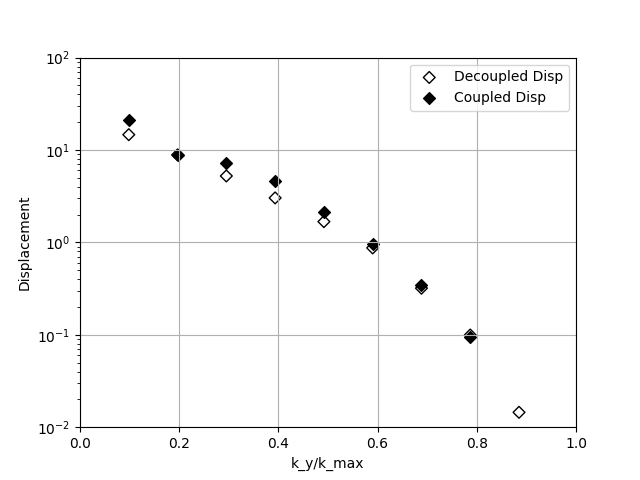

In [4]:
fig, ax = plt.subplots()
data = df[df["Ts/Tm"] == 0.2]
# ax.scatter(data["ky"] / data["k_max (decoupled)"], data["rigid_disp"], label="Rigid Disp")
ax.scatter(
    data["ky"] / data["k_max (decoupled)"],
    data["decoupled_disp"],
    label="Decoupled Disp",
    marker="D",  # Diamond marker
    edgecolors="black",  # Black edge color
    facecolors="none",  # No fill
)
ax.scatter(
    data["ky"] / data["k_max (decoupled)"],
    data["coupled_disp"],
    label="Coupled Disp",
    marker="D",  # Diamond marker
    color="black",  # Black color
)
ax.set_xlabel("k_y/k_max")
ax.set_ylabel("Displacement")
ax.set_yscale("log")
ax.set_ylim(1e-2, 1e2)
ax.set_xlim(0, 1.0)
ax.legend()
ax.grid(True)


In [5]:
# plt.close("all")